# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing
import warnings
warnings.filterwarnings("ignore")

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [2]:
# TODO 1
#   df = pd.read_excel(...)
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls', 
                   index_col = 0)
df.head()
df.isna().sum().sum()

1396

This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [3]:
# TODO 2
#  df1 = ...
df1 = df.fillna(df.mean())
df1.head()
df1.isna().sum().sum()

0

## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [4]:
# TODO 3
#   y = ...
y = df1['Genotype'].values

In [5]:
y = df1.Genotype.astype("category").cat.codes

As predictors, get all but the last four columns of the dataframes.  Store the data matrix into `X` and the names of the columns in `xnames`.

In [6]:
# TODO 4
#   xnames = ...
#   X = ...
xnames = df1.columns[:-4]
X = np.array(df1[xnames].values)

Split the data into training and test with 30% allocated for test.  You can use the train

In [7]:
from sklearn.model_selection import train_test_split

#Use : shuffle=True, random_state=3 so we all can have same split.
# TODO 5: 
#   Xtr, Xts, ytr, yts = ...

Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3, random_state=3)

Scale the data with the `StandardScaler`.  Store the scaled values in `Xtr1` and `Xts1`. 

In [8]:
from sklearn.preprocessing import StandardScaler

# TODO 6
#  Xtr1 = ...
#  Xts1 = ...

# Create the scaler objects
xscal = StandardScaler()

xscal.fit(Xtr)
# Fit and transform the training data
Xtr1 = xscal.transform(Xtr)

# Transform the test data
Xts1 = xscal.transform(Xts)

Create a `LogisticRegression` object `logreg` and `fit` on the scaled training data.  Set the regularization level to `C=1e5` and use the optimizer `solver=liblinear`. 

In [9]:
# TODO 7
#   logreg = ...
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5,solver='liblinear')
logreg.fit(Xtr1,ytr)

LogisticRegression(C=100000.0, solver='liblinear')

Measure the accuracy of the classifer on test data.  You should get around 94%.  

In [10]:
# TODO 8
#   yhat = ...

from sklearn.metrics import accuracy_score
yhat = logreg.predict(Xts1)
accuracy_score(yts, yhat)

0.9506172839506173

## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  Jse the `plt.stem()` function with the `use_line_collection=True` option.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

<StemContainer object of 3 artists>

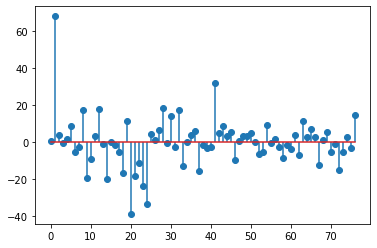

In [11]:
# TODO 9
#   W = ...
#   plt.stem(...)
W = logreg.coef_
W = W.ravel()
plt.stem(W,use_line_collection=True)

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.   Below we will use L1 regression to enforce sparsity.  Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [12]:
ind = np.argsort(np.abs(W))
i1 = ind[-1]
i2 = ind[-2]
n1 = xnames[i1]
n2 = xnames[i2]
print('The two most significant genes are {0:s} and {1:s}'.format(n1,n2))

The two most significant genes are ITSN1_N and BRAF_N


## Cross Validation

To obtain a slightly more accurate result, now perform 10-fold cross validation and measure the average precision, recall and f1-score.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
grid={'C':10.0 **np.arange(-2,3),'penalty':['l1','l2']}
# TODO 11
klf=GridSearchCV(logreg,grid,cv=kf,n_jobs=-1)
klf.fit(Xtr,ytr)
y_pred=klf.predict(Xts)
#print(confusion_matrix(yts,y_pred))
#print(accuracy_score(yts,y_pred))
print(classification_report(yts,y_pred))
mse = np.square(np.subtract(yts,y_pred)).mean()
print('Mean Squared Error %f'% mse)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       176
           1       0.95      0.98      0.97       148

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324

Mean Squared Error 0.030864


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7.

In [14]:
# TODO 12
#   y = ...
y = df1['class']
y = y.astype("category").cat.codes
Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3, random_state=3)
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int8)

Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method.

Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test accuracy across the folds.

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# TODO 13
logreg = LogisticRegression()
ytr=ytr.T
logreg.fit(Xtr,ytr)
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
grid={'C':10.0 **np.arange(-2,3),'penalty':['l1','l2']}
# TODO 11
klf=GridSearchCV(logreg,grid,cv=kf,n_jobs=-1)
klf.fit(Xtr,ytr)
y_pred=klf.predict(Xts)
print(np.array_str(confusion_matrix(yts,y_pred) / confusion_matrix(yts,y_pred).astype(np.float).sum(axis=1), 
                   precision = 4, suppress_small = True))
print(classification_report(yts,y_pred))
print('Accuracy is %f' %accuracy_score(yts,y_pred))
#mean = np.mean()
mse = np.square(np.subtract(yts,y_pred)).mean()
print('Mean Squared Error %f'% mse)


/Users/prachikaagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/prachikaagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/prachikaagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/prachikaagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score o

[[0.875  0.1351 0.     0.     0.027  0.027  0.     0.    ]
 [0.1071 0.7297 0.     0.     0.027  0.0811 0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.975  0.     0.027  0.     0.    ]
 [0.     0.0541 0.     0.     0.9459 0.     0.     0.    ]
 [0.0179 0.     0.     0.     0.     0.973  0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.0179 0.     0.     0.     0.     0.     0.     0.9697]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        56
           1       0.79      0.73      0.76        37
           2       1.00      1.00      1.00        43
           3       1.00      0.97      0.99        40
           4       0.95      0.95      0.95        37
           5       0.88      0.97      0.92        37
           6       1.00      1.00      1.00        41
           7       1.00      0.97      0.98        33

    accuracy                           

/Users/prachikaagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/prachikaagarwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes.

<StemContainer object of 3 artists>

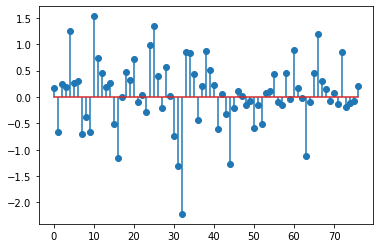

In [16]:
# TODO 14
logreg = LogisticRegression()
ytr=ytr.T
logreg.fit(Xtr,ytr)
yhat = logreg.predict(Xts1)
W = logreg.coef_
l = W[0]
plt.stem(l,use_line_collection=True)

## L1-Regularization

This section is bonus.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [housing demo](../unit05_lasso/demo2_housing.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation 
* You should select around 20 values of `C`.  It is up to you find a good range.
* Make appropriate plots and print out to display your results
* How does the accuracy compare to the accuracy achieved without regularization.

In [17]:
# TODO 15